## EXPLORATORY DATA ANALYSIS: AIRPLANE CRASH ANALYSIS


In [1]:
#Import Required Libraries
import os
import json
import requests
from dotenv import load_dotenv
from pymongo import MongoClient
from bson import ObjectId
from datetime import datetime
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load environment variables - to hide the credential of MongoDB URI
load_dotenv("project.env")
MONGO_URI = os.getenv("MONGO_URI")
GITHUB_URL = "https://raw.githubusercontent.com/Anusha3997/Airplane-Crash-Analysis/main/airplane_crashes.json"
json_file = "airplane_crashes_output.json"
df = pd.read_json(json_file)

#### PHASE-1: Data Collection and MongoDB

<b> <i>Step-1: Data collection<i><b>

In [3]:
#Step-1: Fetch data from GitHub API
def fetch_data(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        print(f"Data successfully downloaded.")
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Failed to download data. Status code: {e}")
        return None

# Function to process dates - to extract valid dates from the dataset and convert them into datetime objects for further analysis
def parse_dates(data):
    dates = []
    for record in data:
        try:
            dates.append(datetime.strptime(record["Date"], "%m/%d/%Y"))
        except (KeyError, ValueError):
            pass
    return dates
# Function to format ObjectId for JSON serialization - to avoid MongoDB ObjectId values serialization errors
def convert_objectid(obj):
    if isinstance(obj, dict):
        return {k: convert_objectid(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_objectid(i) for i in obj]
    elif isinstance(obj, ObjectId):
        return str(obj)
    return obj
data = fetch_data(GITHUB_URL) #Calling to fetech data

Data successfully downloaded.


In [5]:
#Step-1.2: Display Basic Information
if data:
    print("\nBasic Infromation about the data")
    print("Data Source: GitHub Repository - Anusha3997/Airplane-Crash-Analysis")
    print(f"Total records: {len(data)}")
    dates = parse_dates(data)
    if dates:
        print(f"Data Time Frame: {min(dates).strftime('%Y-%m-%d')} to {max(dates).strftime('%Y-%m-%d')}")
    print(f"Data Attributes: {list(data[0].keys())}\n")
    print("Data Structure:")
    print(df.info())
    def format_sample_record (record):
        record['_id'] = str(record.get('_id','N/A'))
        print("\n Sample JSON Structure:")
        print(json.dumps (record, indent=4))

format_sample_record(data[0])        


Basic Infromation about the data
Data Source: GitHub Repository - Anusha3997/Airplane-Crash-Analysis
Total records: 5268
Data Time Frame: 1908-09-17 to 2009-06-08
Data Attributes: ['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type', 'Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary']

Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5268 non-null   datetime64[ns]
 1   Time          5268 non-null   object        
 2   Location      5268 non-null   object        
 3   Operator      5268 non-null   object        
 4   Flight #      5268 non-null   object        
 5   Route         5268 non-null   object        
 6   Type          5268 non-null   object        
 7   Registration  5268 non-null   object        
 8   cn/In         5268 non-null   object        
 9   

<b><i>Step 2: Write JSON data to MongoDB<i><b>

In [7]:
# Step-2.1: Function to insert/update data in MongoDB
def insert_to_mongo(data, uri):
    if uri:
        print("\nMongoDB connected.")
    if not uri:
        print("\nMongoDB URI not found. Check your .env file.")
        return
    
    client = MongoClient(MONGO_URI)
    collection = client["airplane_crashes_db"]["crashes"]

    collection.drop() #Deletes any records already found in MongoDB Atlas
    print("Dropped any existing collection.")
    
    collection. insert_many (data)
    print(f"\nInserted {collection.count_documents ({})} records into MongoDB Atlas.")

In [9]:
# Step-2.2: Function to save data locally
def save_to_json(data, json_file):
    with open(json_file, "w") as f:
        json.dump(convert_objectid(data), f, indent=4)
    print(f"\nData saved locally as {json_file}.")

In [11]:
#Calling functions 
insert_to_mongo(data, MONGO_URI)
save_to_json(data, json_file)


MongoDB connected.
Dropped any existing collection.

Inserted 5268 records into MongoDB Atlas.

Data saved locally as airplane_crashes_output.json.


#### PHASE-2: Data Modeling

<b><i>Step 1: Extract data from MongoDB<i><b>

In [13]:
#Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client["airplane_crashes_db"]
collection = db["crashes"]

#Extracting relavant data
extracted_data = []
for record in collection.find({}, {"Date": 1, "Location": 1, "Operator": 1, "Type": 1, "Aboard": 1, "Fatalities": 1, "_id": 0}):
    if all(key in record for key in ["Date", "Location", "Operator", "Type", "Aboard", "Fatalities"]):
        extracted_data.append(record)
print(f"Extracted {len(extracted_data)} records from MongoDB.")

Extracted 5268 records from MongoDB.


<b><i>Step 2: Insert data into SQLite<i><b>

In [15]:
# Connect to SQLite
sqlite_db = "airplane_crashes.sqlite"
conn = sqlite3.connect(sqlite_db)
cursor = conn.cursor()

#Create table crashes
cursor.execute("DROP TABLE IF EXISTS crashes")
cursor.execute('''
    CREATE TABLE IF NOT EXISTS crashes (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Date TEXT,
        Location TEXT,
        Operator TEXT,
        Type TEXT,
        Aboard INTEGER,
        Fatalities INTEGER
    )
''')
conn.commit() # Saves the table
print("SQLite table 'crashes' created successfully.")

SQLite table 'crashes' created successfully.


In [17]:
#Insert Data into SQLite
for entry in extracted_data:
    try:
        cursor.execute('''
            INSERT OR IGNORE INTO crashes (Date, Location, Operator, Type, Aboard, Fatalities)
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (entry["Date"], entry["Location"], entry["Operator"], entry["Type"], entry["Aboard"], entry["Fatalities"]))

    except Exception as e:
        print(f"Skipped a record due to error: {e}")

conn.commit()
print(f"\nSuccessfully inserted records into SQLite.")


Successfully inserted records into SQLite.


In [19]:
# Verify Data Count
cursor.execute("SELECT COUNT(*) FROM crashes")
row_count = cursor.fetchone()[0]
print(f"\nSQLite database contains {row_count} records.")


SQLite database contains 5268 records.


In [21]:
# Display Sample record
cursor.execute("SELECT * FROM crashes LIMIT 1")
first_record = cursor.fetchone()
print(f"\nFirst record in the SQLite database: {first_record}")

# Close Connections
conn.close()
client.close()


First record in the SQLite database: (1, '09/17/1908', 'Fort Myer, Virginia', 'Military - U.S. Army', 'Wright Flyer III', 2, 1)


#### PHASE-3: Data Analysis and Visualization

<b><i> Step 1: Extract data from SQLite and Load the Data into a Pandas DataFrame <i><b>

In [23]:
DB_FILE = "airplane_crashes.sqlite" 
TABLE_NAME = "crashes"  # Data is stored in crashes table

# Connect to SQLite and fetch data
conn = sqlite3.connect(DB_FILE)
query = f"SELECT Date, Operator, Location, Fatalities, Aboard FROM {TABLE_NAME};"
df = pd.read_sql(query, conn) #feteching data and loading to dataframe name df
conn.close()

# Display first two rows 
print("Extracted Data Sample:")
print(df.head(2))

Extracted Data Sample:
         Date              Operator                 Location Fatalities Aboard
0  09/17/1908  Military - U.S. Army      Fort Myer, Virginia          1      2
1  07/12/1912  Military - U.S. Navy  AtlantiCity, New Jersey          5      5


<b><i> Step 2: Data Cleaning <i><b>

In [25]:
print("\nChecking for Missing Values:")
print(df.isnull().sum())

# Handling missing values
df.dropna(subset=["Fatalities", "Aboard"], inplace=True)  # Remove rows with missing Fatalities/Aboard
df["Fatalities"] = pd.to_numeric(df["Fatalities"], errors="coerce").fillna(0).astype(int)
df["Aboard"] = pd.to_numeric(df["Aboard"], errors="coerce").fillna(0).astype(int)

# Convert 'Date' column to datetime format for better visualization
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


Checking for Missing Values:
Date          0
Operator      0
Location      0
Fatalities    0
Aboard        0
dtype: int64


In [27]:
# Save cleaned data to CSV
df.to_csv("cleaned_airplane_crashes.csv", index=False)
print("Data cleaned and saved as cleaned_airplane_crashes.csv")

Data cleaned and saved as cleaned_airplane_crashes.csv


<b><i> Step 3: Data Analysis <i><b>

In [29]:
print("\n Basic Statistics:")
print(df.describe())


 Basic Statistics:
                                Date   Fatalities       Aboard
count                           5268  5268.000000  5268.000000
mean   1971-10-23 15:50:42.369020480    20.022589    27.439446
min              1908-09-17 00:00:00     0.000000     0.000000
25%              1954-04-11 18:00:00     3.000000     5.000000
50%              1973-03-04 00:00:00     9.000000    13.000000
75%              1990-06-26 18:00:00    23.000000    30.000000
max              2009-06-08 00:00:00   583.000000   644.000000
std                              NaN    33.175910    43.023370


In [31]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5268 non-null   datetime64[ns]
 1   Operator    5268 non-null   object        
 2   Location    5268 non-null   object        
 3   Fatalities  5268 non-null   int64         
 4   Aboard      5268 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 205.9+ KB
None


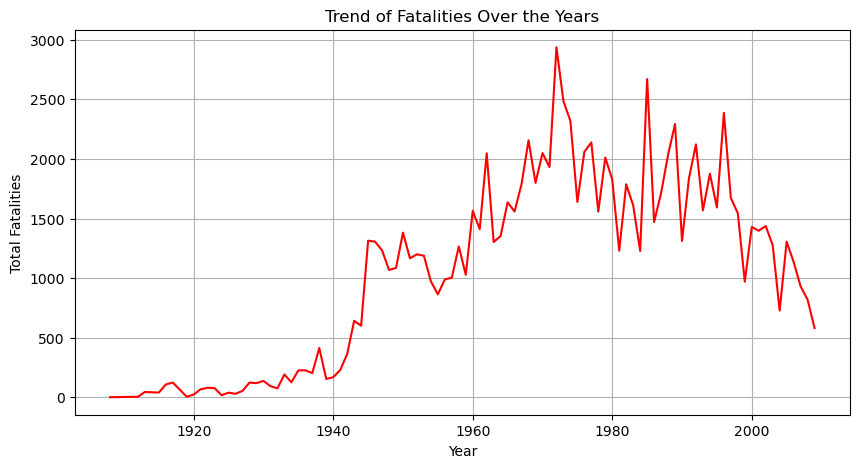

In [33]:
# Visualization 1: Trend of Fatalities Over Time
plt.figure(figsize=(10, 5))
df.groupby(df["Date"].dt.year)["Fatalities"].sum().plot(kind="line", color="red")
plt.title("Trend of Fatalities Over the Years")
plt.xlabel("Year")
plt.ylabel("Total Fatalities")
plt.grid()
plt.show()


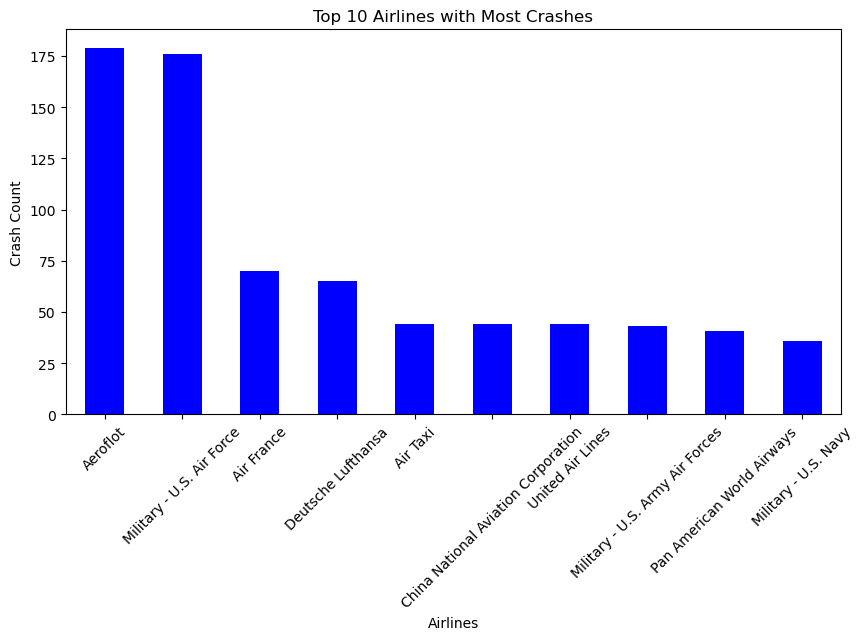

In [35]:
# Visualization 2: Top 10 Airlines with Most Crashes
plt.figure(figsize=(10, 5))
df["Operator"].value_counts().head(10).plot(kind="bar", color="blue")
plt.title("Top 10 Airlines with Most Crashes")
plt.xlabel("Airlines")
plt.ylabel("Crash Count")
plt.xticks(rotation=45)
plt.show()

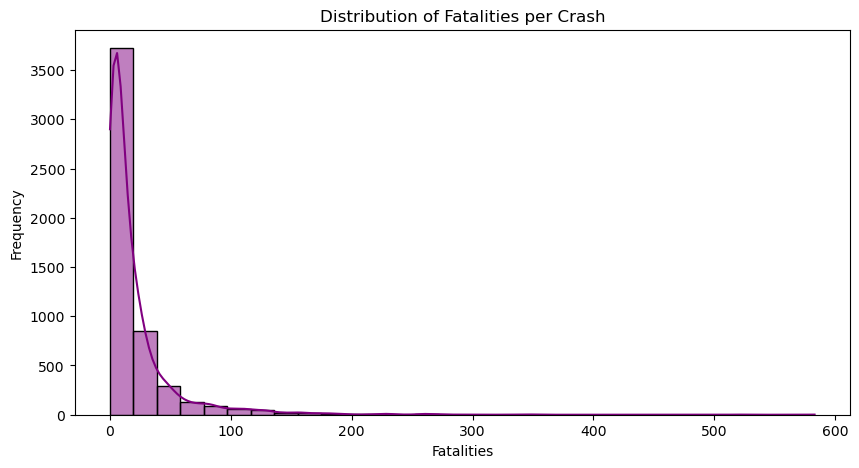

In [37]:
# Visualization 3: Histogram of Fatalities per Crash
plt.figure(figsize=(10, 5))
sns.histplot(df["Fatalities"], bins=30, kde=True, color="purple")
plt.title("Distribution of Fatalities per Crash")
plt.xlabel("Fatalities")
plt.ylabel("Frequency")
plt.show()


In [39]:
print("Data analysis and visualizations completed.")

Data analysis and visualizations completed.
